In [1]:
import random
import datetime

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import tree
import joblib

import scipy

In [4]:
import group_tempreture_model

In [5]:
plt.rcParams["figure.figsize"] = (15, 10)

In [6]:
def convertFahrenheitToCelsius(f):
    return (f - 32) / 1.8

## load random forest model

In [7]:
filename_min = '../../model/comfort_minmax_model/min_random_forest_model.sav'
filename_max = '../../model/comfort_minmax_model/max_random_forest_model.sav'

In [8]:
rfr_min = joblib.load(filename_min)
rfr_max = joblib.load(filename_max)

## create test data

### load env_temp data

In [9]:
env_temp_file_path = '../data/hobo/env_05_processed.csv'
df_env_temp = pd.read_csv(env_temp_file_path)

In [10]:
df_env_temp

,time,env_temp
0,2020-12-09 11:45:00,69.557
1,2020-12-09 11:46:00,69.600
2,2020-12-09 11:47:00,69.685
3,2020-12-09 11:48:00,69.728
4,2020-12-09 11:49:00,69.771
...,...,...
221,2020-12-09 15:26:00,70.803
222,2020-12-09 15:27:00,70.930
223,2020-12-09 15:28:00,71.060
224,2020-12-09 15:29:00,71.060


In [11]:
df_env_temp.time = pd.to_datetime(df_env_temp.time)

In [12]:
time_start = datetime.datetime.strptime('12/09/20 13:20:00', '%m/%d/%y %H:%M:%S')
time_end = datetime.datetime.strptime('12/09/20 15:20:00', '%m/%d/%y %H:%M:%S')

t_list = []

t = time_start
while t <= time_end:
    t_list.append(t)
    t = t + pd.Timedelta('10min')

t_Series = pd.Series(t_list)

In [13]:
df_env_temp_selected = df_env_temp.loc[df_env_temp['time'].isin(t_Series)]

In [14]:
d1 = {}
for idxm, row in df_env_temp_selected.iterrows():
    d1[str(row['time'])] = row['env_temp']

In [15]:
d1

{'2020-12-09 13:20:00': 72.869,
 '2020-12-09 13:30:00': 76.63600000000002,
 '2020-12-09 13:40:00': 77.029,
 '2020-12-09 13:50:00': 74.33800000000002,
 '2020-12-09 14:00:00': 72.91199999999998,
 '2020-12-09 14:10:00': 72.05,
 '2020-12-09 14:20:00': 75.85300000000002,
 '2020-12-09 14:30:00': 77.464,
 '2020-12-09 14:40:00': 76.464,
 '2020-12-09 14:50:00': 73.429,
 '2020-12-09 15:00:00': 71.533,
 '2020-12-09 15:10:00': 70.459,
 '2020-12-09 15:20:00': 69.814}

In [16]:
ts_env_temp = [[row['env_temp']] for idxm, row in df_env_temp_selected.iterrows()]

In [17]:
ts_env_temp = [convertFahrenheitToCelsius(x[0]) for x in ts_env_temp]

In [18]:
ts_env_temp

[22.705,
 24.79777777777779,
 25.01611111111111,
 23.52111111111112,
 22.728888888888875,
 22.249999999999996,
 24.36277777777779,
 25.257777777777775,
 24.702222222222222,
 23.016111111111112,
 21.962777777777777,
 21.366111111111113,
 21.007777777777772]

### load features data

In [19]:
pth_data = '../data/test.csv'
df_origin = pd.read_csv(pth_data)

In [20]:
df_origin

,time,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act
0,2020-12-09 13:20:00,1.62,52,1,19.814053,26,83.779,36.837,97.0,58.0,31.065,8.696614,4,5,0.61,1.0
1,2020-12-09 13:30:00,1.62,52,1,19.814053,26,87.073,39.856,119.0,NaN,31.588,14.716620,3,6,0.61,4.0
2,2020-12-09 13:40:00,1.62,52,1,19.814053,26,88.947,40.446,122.0,NaN,31.772,13.199184,3,6,0.61,4.0
3,2020-12-09 13:50:00,1.62,52,1,19.814053,26,86.437,45.924,106.0,NaN,31.641,7.708510,4,3,0.74,1.0
4,2020-12-09 14:00:00,1.62,52,1,19.814053,26,83.779,45.179,96.5,NaN,31.274,5.524036,3,2,0.74,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2020-12-09 14:40:00,1.77,90,-1,28.727377,28,84.654,15.000,121.5,NaN,31.955,11.877829,2,7,0.74,4.0
74,2020-12-09 14:50:00,1.77,90,-1,28.727377,28,86.097,16.270,104.0,NaN,31.693,13.723230,4,4,0.61,1.0
75,2020-12-09 15:00:00,1.77,90,-1,28.727377,28,85.915,15.000,106.0,86.0,32.474,12.256653,5,4,0.61,1.0
76,2020-12-09 15:10:00,1.77,90,-1,28.727377,28,85.374,25.480,120.0,NaN,31.588,11.623549,5,3,1.00,4.0


In [21]:
df_origin.shape

(78, 16)

In [22]:
# for i in range(df_origin.shape[0]):
#     t = df_origin.iloc[i, :]['time']
#     df_origin['env_temp'][i] = d1[t]

In [23]:
df_sort_by_time = df_origin.sort_values(by="time")

In [24]:
df_sort_by_time = df_sort_by_time.drop(columns=['time'])

In [25]:
df_sort_by_time[df_sort_by_time[['env_temp']].isna().env_temp]
# no na in env_temp

,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act


In [26]:
imp = SimpleImputer(strategy='mean')
df_imp = pd.DataFrame(imp.fit_transform(df_sort_by_time), columns=df_sort_by_time.columns)

In [27]:
df_imp

,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act
0,1.62,52.0,1.0,19.814053,26.0,83.779,36.837,97.0,58.000000,31.065000,8.696614,4.0,5.0,0.61,1.0
1,1.80,60.0,-1.0,18.518519,24.0,82.508,15.000,86.0,54.890244,30.246000,0.425823,3.0,6.0,0.74,1.0
2,1.71,64.0,-1.0,21.887076,27.0,85.667,26.673,97.5,57.000000,31.222000,1.089335,4.0,4.0,1.00,1.0
3,1.64,54.0,1.0,20.077335,24.0,83.467,29.681,79.0,13.000000,30.854000,0.270284,5.0,6.0,0.61,1.0
4,1.77,90.0,-1.0,28.727377,28.0,85.374,30.650,115.0,90.500000,31.772000,8.124499,1.0,6.0,1.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,1.68,62.0,-1.0,21.967120,29.0,76.507,26.880,83.5,4.000000,31.745000,1.934344,4.0,3.0,0.74,1.0
74,1.64,54.0,1.0,20.077335,24.0,88.810,30.999,88.0,50.000000,32.526000,4.887415,2.0,1.0,1.00,1.0
75,1.62,52.0,1.0,19.814053,26.0,86.981,34.340,94.0,44.000000,31.588000,2.129392,3.0,3.0,1.00,1.0
76,1.71,64.0,-1.0,21.887076,27.0,86.664,28.598,89.0,49.500000,32.161307,0.385849,4.0,3.0,0.74,1.0


In [28]:
dfs = []
for i in range(13):
    dfs.append(df_imp.iloc[6 * i:6 * i + 6,:])

In [29]:
dfs

[   height  weight  gender        bmi   age  env_temp      rh  heart_rate  \
 0    1.62    52.0     1.0  19.814053  26.0    83.779  36.837        97.0   
 1    1.80    60.0    -1.0  18.518519  24.0    82.508  15.000        86.0   
 2    1.71    64.0    -1.0  21.887076  27.0    85.667  26.673        97.5   
 3    1.64    54.0     1.0  20.077335  24.0    83.467  29.681        79.0   
 4    1.77    90.0    -1.0  28.727377  28.0    85.374  30.650       115.0   
 5    1.68    62.0    -1.0  21.967120  29.0    80.139  26.901        80.0   
 
    stress_level  skin_temp       eda   TC   TS   Clo  Act  
 0     58.000000  31.065000  8.696614  4.0  5.0  0.61  1.0  
 1     54.890244  30.246000  0.425823  3.0  6.0  0.74  1.0  
 2     57.000000  31.222000  1.089335  4.0  4.0  1.00  1.0  
 3     13.000000  30.854000  0.270284  5.0  6.0  0.61  1.0  
 4     90.500000  31.772000  8.124499  1.0  6.0  1.00  1.0  
 5     16.000000  32.161307  0.838267  3.0  6.0  1.00  1.0  ,
     height  weight  gender    

## exmine min

In [30]:
X_columns = ['height', 'weight', 'gender', 'bmi', 'age', 'rh', \
                      'heart_rate', 'stress_level', 'skin_temp', 'eda', \
                      'Clo', 'Act']

In [31]:
minTs = []
for df in dfs:
    X = df[X_columns]
    y = rfr_min.predict(X)
    y = np.array([convertFahrenheitToCelsius(f) for f in y])
    minTs.append(y)

In [32]:
minTs

[array([23.68871181, 24.13334236, 23.28875903, 24.15342083, 23.41481736,
        23.14443542]),
 array([24.46612014, 23.93509444, 24.014125  , 23.83195625, 24.96646875,
        25.09142292]),
 array([24.4398    , 24.88271319, 23.88707014, 23.80060764, 23.81703889,
        25.11992222]),
 array([24.63261806, 24.54895   , 24.75735139, 23.70207847, 23.80696111,
        23.27901528]),
 array([24.56517708, 24.68382014, 23.68819375, 23.79120694, 24.60770625,
        23.31553403]),
 array([23.63471458, 24.51091667, 23.89166875, 24.05070278, 24.10372708,
        23.47079931]),
 array([24.02761389, 23.83337778, 24.06745694, 23.69293611, 23.80258472,
        25.42400069]),
 array([23.23329861, 24.05533264, 23.21234653, 24.31001875, 23.727475  ,
        24.17499097]),
 array([24.29526528, 24.17477569, 23.22842083, 23.99484722, 23.61070625,
        23.00417778]),
 array([24.03264444, 23.62505139, 24.5052625 , 24.15108125, 23.65722986,
        23.96429722]),
 array([23.87807778, 23.84083403, 23.711

## exmine max

In [33]:
maxTs = []
for df in dfs:
    X = df[X_columns]
    y = rfr_max.predict(X)
    y = np.array([convertFahrenheitToCelsius(f) for f in y])
    maxTs.append(y)

In [34]:
maxTs

[array([26.27703074, 27.90420593, 27.58898963, 25.86562815, 27.75616333,
        27.55031222]),
 array([26.27081926, 27.61381333, 27.70346519, 27.59594889, 28.18205519,
        26.25948741]),
 array([26.28015037, 28.0669037 , 27.67353741, 27.6048    , 27.80229148,
        26.27197148]),
 array([26.30353593, 27.57229333, 28.12122963, 27.65460185, 27.73382185,
        26.1963337 ]),
 array([27.57418037, 28.0790263 , 27.80899667, 27.68873111, 26.11608444,
        26.14217444]),
 array([26.33746926, 28.06146481, 27.71702556, 27.75545481, 27.55567296,
        26.35920815]),
 array([27.56627593, 27.69126   , 27.74897704, 26.57487889, 26.51448556,
        28.14796222]),
 array([27.66956963, 27.73663296, 27.64456333, 26.42571148, 26.37172963,
        28.04690519]),
 array([26.41241519, 27.70911   , 27.63543778, 28.15354074, 26.3046863 ,
        27.70760556]),
 array([26.34811519, 27.5431437 , 28.18453333, 26.37030963, 27.63393519,
        27.69298556]),
 array([27.74323111, 26.3578463 , 27.552

## compute group optimal tempreture

### use sensitive first model

In [35]:
ts_sensitive_model = []
for i in range(13):
    minT = minTs[i]
    maxT = maxTs[i]
    ogt = group_tempreture_model.OptimalGroupTempreture(minT, maxT)
    t = ogt.getTempreture(model='sensitive first')
    ts_sensitive_model.append(t)

sensitive first model
sensitive first model
sensitive first model
sensitive first model
sensitive first model
sensitive first model
sensitive first model
sensitive first model
sensitive first model
sensitive first model
sensitive first model
sensitive first model
sensitive first model


In [36]:
ts_sensitive_model

[25.30376415379026,
 25.753029666418357,
 25.741739211242777,
 25.643586367871546,
 25.596346971861532,
 25.561920305108814,
 25.75415580040059,
 25.50299207278731,
 25.470489310534266,
 25.569614941431553,
 25.434084101785935,
 25.71575232011872,
 25.478485957683315]

### use otd model

In [37]:
ts_otd_model = []
for i in range(13):
    minT = minTs[i]
    maxT = maxTs[i]
    ogt = group_tempreture_model.OptimalGroupTempreture(minT, maxT)
    t = ogt.getTempreture(model='otd model', ppd=0.5)
    ts_otd_model.append(t)

otd model
otd model
otd model
otd model
otd model
otd model
otd model
otd model
otd model
otd model
otd model
otd model
otd model


In [38]:
ts_otd_model

[25.0,
 25.650000000000002,
 25.7,
 25.45,
 25.4,
 25.450000000000003,
 26.0,
 25.35,
 25.299999999999997,
 25.450000000000003,
 25.1,
 26.0,
 25.599999999999998]

### auto judge which model to use

In [39]:
ts_auto = []
for i in range(13):
    minT = minTs[i]
    maxT = maxTs[i]
    ogt = group_tempreture_model.OptimalGroupTempreture(minT, maxT)
    t = ogt.getTempreture(sensitiveRange=2)
    ts_auto.append(t)

sensitive first model
sensitive people percentage: 0.16666666666666666
sensitive first model
sensitive people percentage: 0.3333333333333333
sensitive first model
sensitive people percentage: 0.3333333333333333
sensitive first model
sensitive people percentage: 0.16666666666666666
sensitive first model
sensitive people percentage: 0.16666666666666666
otd model
otd model
otd model
otd model
otd model
otd model
otd model
otd model


In [40]:
ts_auto

[25.30376415379026,
 25.753029666418357,
 25.741739211242777,
 25.643586367871546,
 25.596346971861532,
 25.450000000000003,
 26.0,
 25.35,
 25.299999999999997,
 25.450000000000003,
 25.1,
 26.0,
 25.599999999999998]

# draw

In [41]:
time_start = datetime.datetime.strptime('12/09/20 13:20:00', '%m/%d/%y %H:%M:%S')
time_end = datetime.datetime.strptime('12/09/20 15:20:00', '%m/%d/%y %H:%M:%S')

t_list = []

t = time_start
while t <= time_end:
    t_list.append(t)
    t = t + pd.Timedelta('10min')

t_Series = pd.Series(t_list)

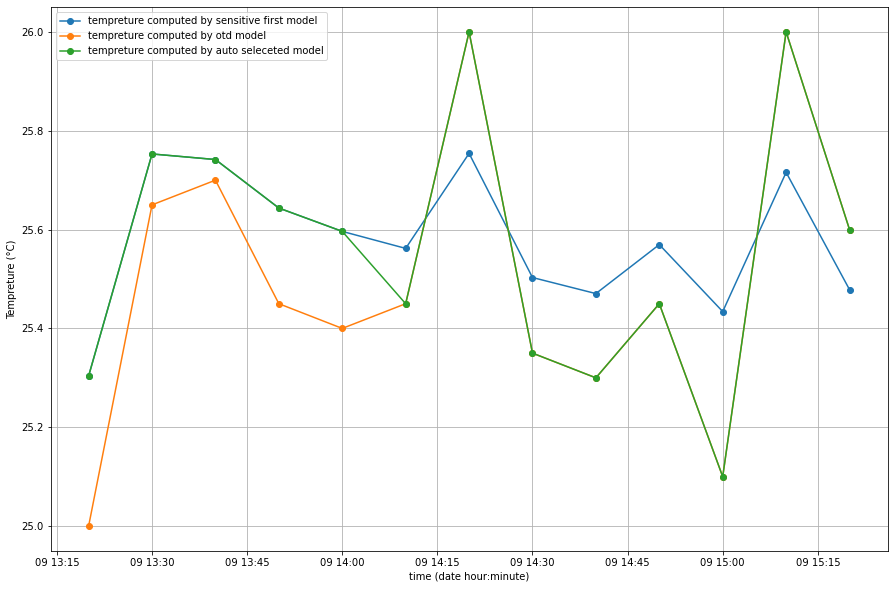

In [42]:
plt.plot(t_Series, ts_sensitive_model, marker='o', label="tempreture computed by sensitive first model")
plt.plot(t_Series, ts_otd_model, marker='o', label="tempreture computed by otd model")
plt.plot(t_Series, ts_auto, marker='o', label="tempreture computed by auto seleceted model")

plt.xlabel('time (date hour:minute)')
plt.ylabel('Tempreture (°C)')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()

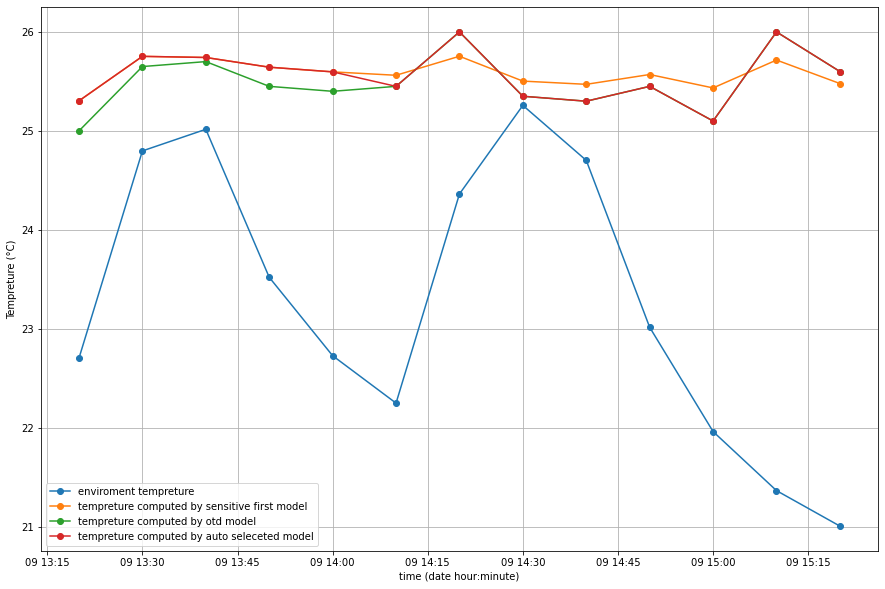

In [43]:
plt.plot(t_Series, ts_env_temp, marker='o', label="enviroment tempreture")
plt.plot(t_Series, ts_sensitive_model, marker='o', label="tempreture computed by sensitive first model")
plt.plot(t_Series, ts_otd_model, marker='o', label="tempreture computed by otd model")
plt.plot(t_Series, ts_auto, marker='o', label="tempreture computed by auto seleceted model")

plt.xlabel('time (date hour:minute)')
plt.ylabel('Tempreture (°C)')
plt.legend(loc='lower left')
plt.grid(True)

plt.show()

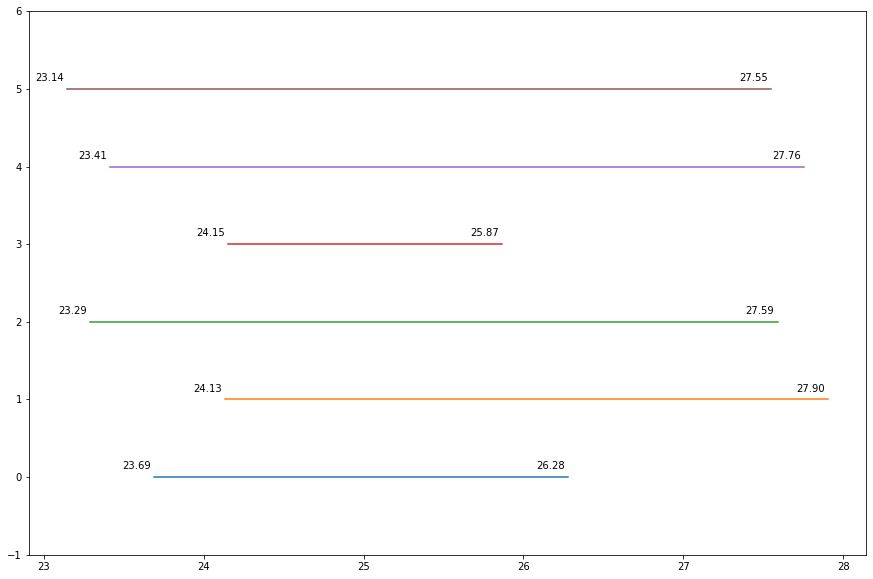

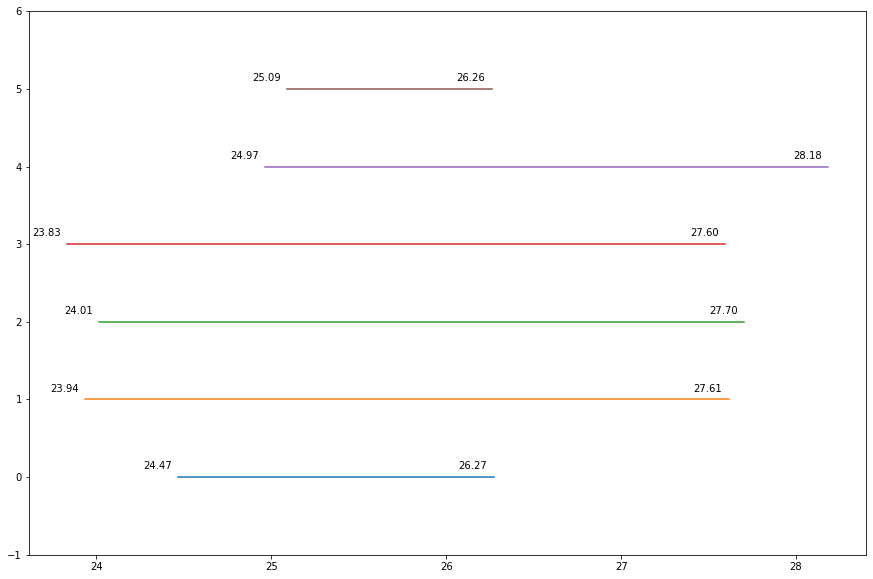

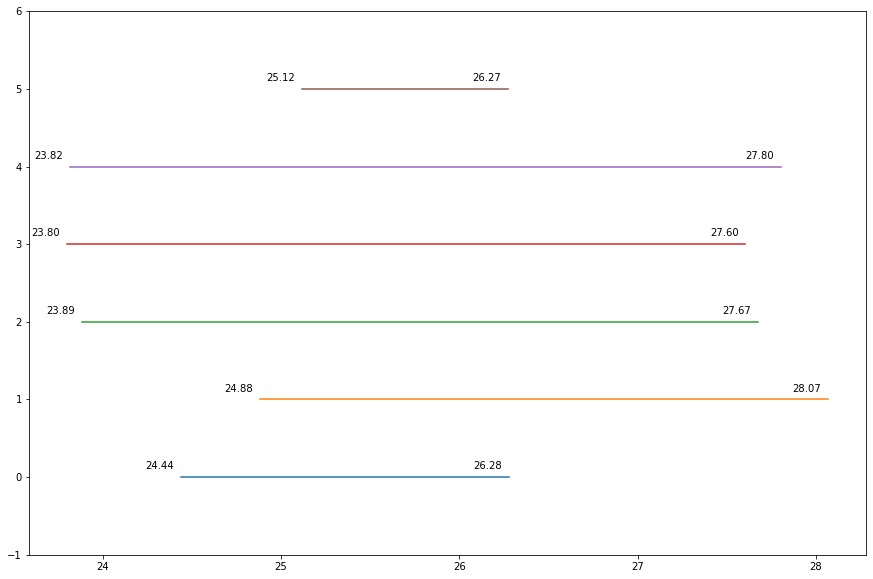

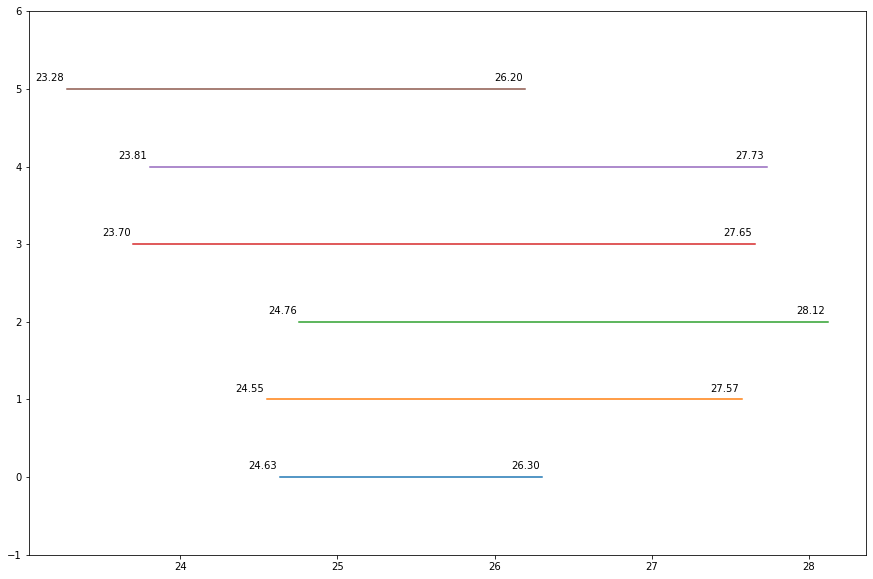

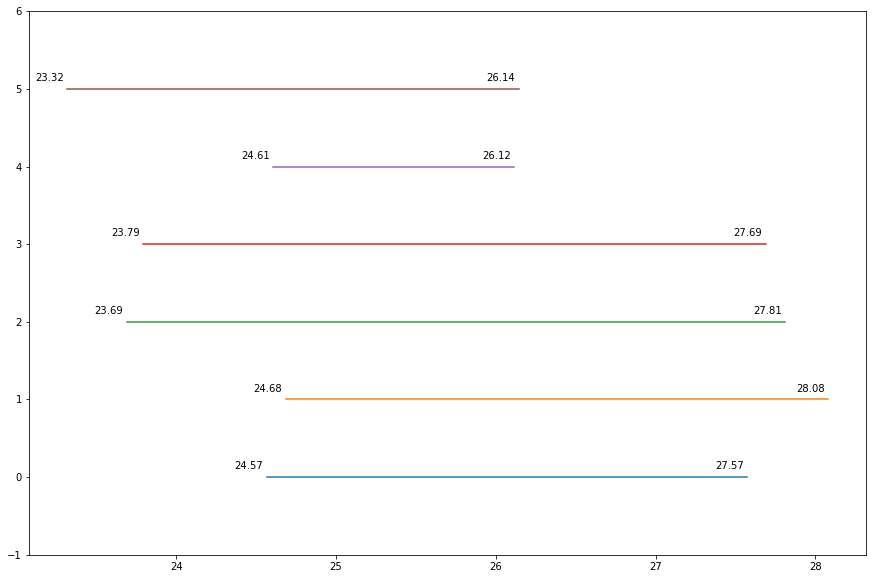

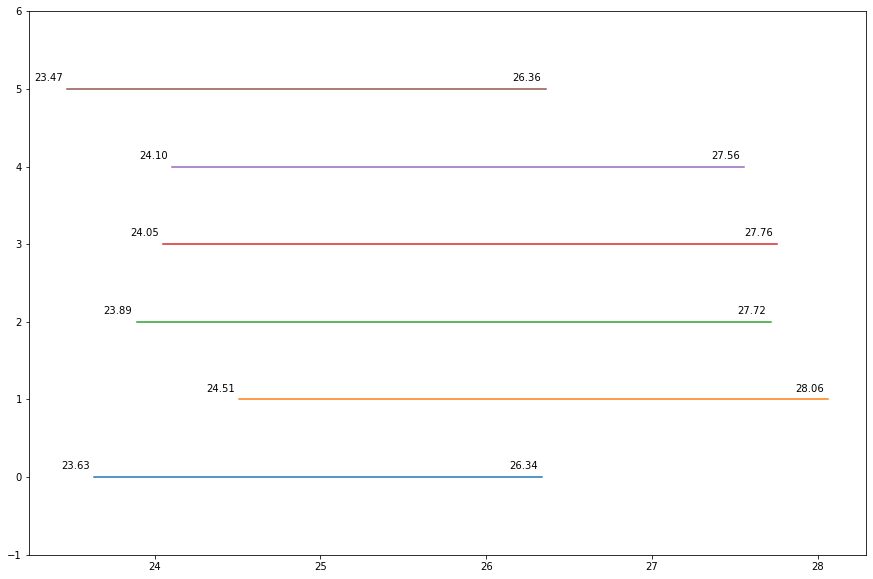

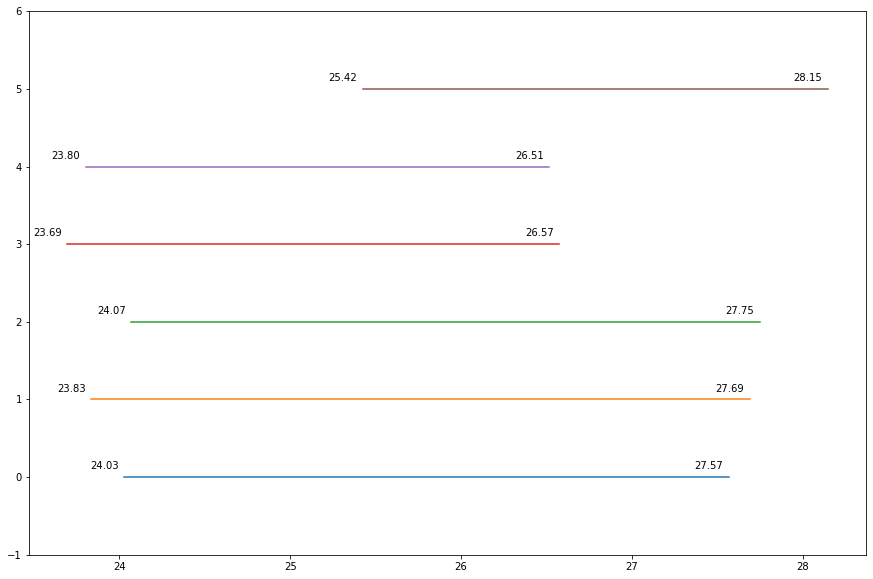

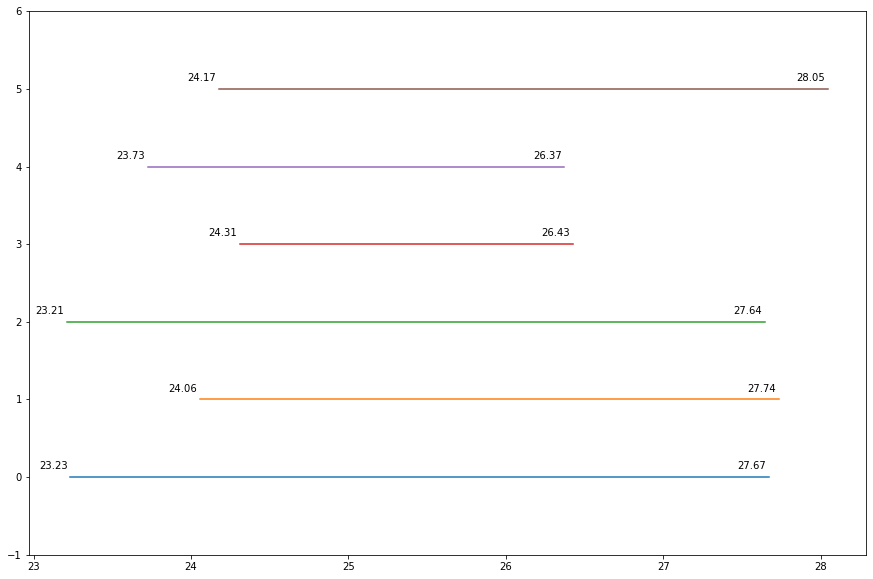

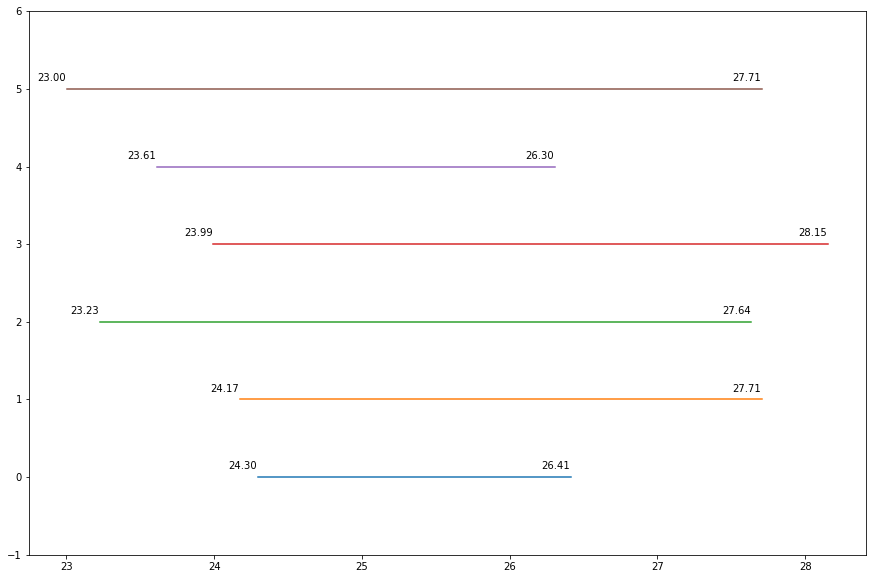

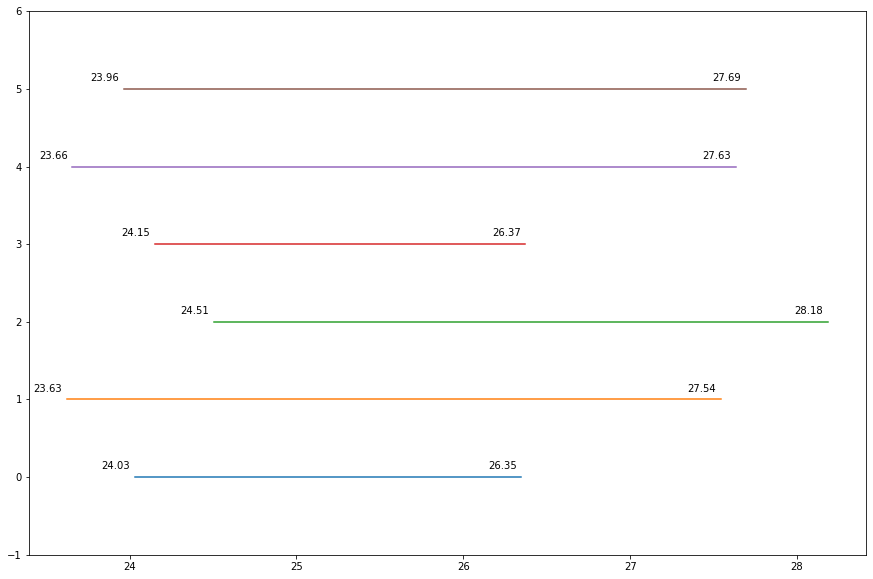

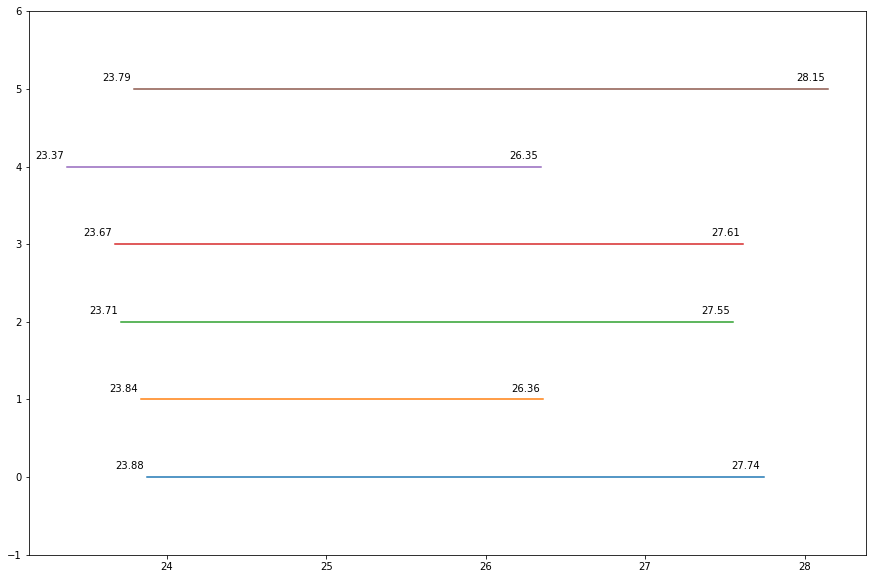

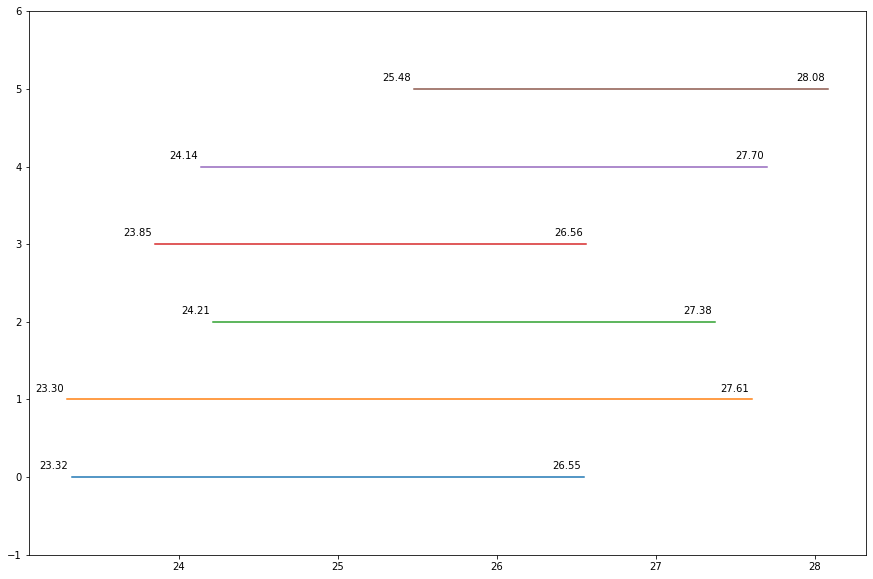

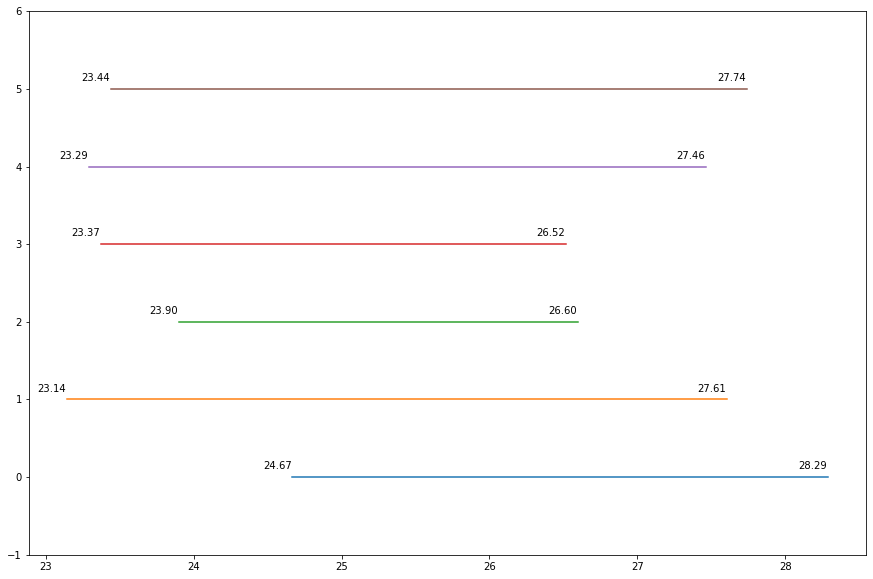

In [44]:
# draw comfort zone
for i in range(len(minTs)):
    plt.ylim(-1, 6)
    for j in range(len(minTs[0])):
        plt.plot([minTs[i][j], maxTs[i][j]],[j, j])
    # tag comfort zone min $ max
    for j in range(len(minTs[0])):
        plt.text(minTs[i][j]-0.2, j+0.1, "%.2f" % minTs[i][j])
        plt.text(maxTs[i][j]-0.2, j+0.1, "%.2f" % maxTs[i][j])
    plt.show()